In [1]:
import keras
from keras.models import Model
from keras.models import load_model
from keras.utils.np_utils import to_categorical
import sys
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import copy
from keras import backend as K
from keras.utils import generic_utils

from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

import keras
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.preprocessing import image
import requests
from skimage.segmentation import slic, felzenszwalb
import matplotlib.pylab as pl
import numpy as np


from PIL import Image

Using TensorFlow backend.


In [2]:
!{sys.executable} -m pip install shap
!{sys.executable} -m pip install keras-vis
import shap
from vis import visualization

     |████████████████████████████████| 225kB 3.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/bf/26/bd/912db1314f1cef0171d9b7f128dd01e8b8c92ed8d0062e632d
Successfully built shap


In [3]:
from google.colab import files, drive
drive.mount('/content/gdrive', force_remount=True) # to ensure that the process can be easily redone in the same runtime

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
os.chdir('/content/gdrive/My Drive/zero_to_deep_learning_udemy/Project')

In [5]:
model = load_model('inception_saved_tf_87.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [6]:
test_df = pd.read_pickle('NvAndMelTestSetG2.zip')
test_df['idx'] = np.where(test_df['id'] == 'mel', 0 , 1)
features=test_df.drop(columns=['idx'], axis = 1)
target=test_df['idx']
features = np.asarray(features['image'].tolist())
features2 = features / 255

target_cat  = to_categorical(target, num_classes = 2)
print('Unseen set') 
#print(model.evaluate(features, target_cat))

y_pred = model.predict(features2, verbose=1)

y_pred2 = np.argmax(y_pred, axis=1)

df = pd.DataFrame(columns=['ID', 'Dx', '% Mel', '% Nev'],index=[i for i in range(400)])
dx_d = {}
Pmel = {}
Pnev = {}
df['ID'] = df.index  
y_test_cat = target_cat
for ind in range(400):
    if y_test_cat[ind][0] == 1.0:
        diagnosis = 'Melanoma'
    elif y_test_cat[ind][1] == 1.0:
        diagnosis = 'Nevus'
    dx_d[ind] = diagnosis
    Pmel[ind] = y_pred[ind][0]
    Pnev[ind] = y_pred[ind][1]
    
    
df['Dx'] = df['ID'].map(dx_d)
df['% Mel'] = df['ID'].map(Pmel)
df['% Nev'] = df['ID'].map(Pnev)

df = df.astype({"% Mel": float, "% Nev": float})

print(df.head())

Unseen set
400/400 [==============================] - 9s 23ms/step
   ID        Dx     % Mel     % Nev
0   0  Melanoma  0.296756  0.703244
1   1  Melanoma  0.997449  0.002551
2   2  Melanoma  0.686119  0.313881
3   3  Melanoma  0.999461  0.000539
4   4  Melanoma  0.933109  0.066891


In [0]:
# SHAP utility functions
# define a function that depends on a binary mask representing if an image region is hidden
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    #plt.imshow(out)           
    return out

  
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out
  

In [0]:
def Shap(index, model, mode, save = False):
    
    image = X_test[index]
    
    def f(z):
        return model.predict(preprocess_input(mask_image(z, segments_slic, img_orig, 255)))
    feature_names = {'0': ['n01', 'mel'],
                       '1': ['n02', 'nev']}
    class_names = feature_names
    file = image
    img = Image.fromarray(image)
    img_orig = image
    
    segments_slic = slic(img, compactness=3, sigma=13, max_size_factor = 3, 
                         min_size_factor = 0.5, convert2lab = True,
                         enforce_connectivity = True)
   
  
    num_seg = len(np.unique(segments_slic))
    # use Kernel SHAP to explain the network's predictions
    explainer = shap.KernelExplainer(f, np.zeros((1,num_seg)))
    shap_values = explainer.shap_values(np.ones((1,num_seg)), nsamples=2000) # runs VGG16 1000 times
    
    
    
    # get the top predictions from the model
    preds = model.predict(np.expand_dims(img_orig.copy() / 255, axis=0))
    print(preds)
    top_preds = np.argsort(-preds)
    
    
    from matplotlib.colors import LinearSegmentedColormap
    colors = []
    for l in np.linspace(1,0,100):
        colors.append((245/255,39/255,87/255,l))
    for l in np.linspace(0,1,100):
        colors.append((24/255,196/255,93/255,l))
    cm = LinearSegmentedColormap.from_list("shap", colors)
    
    # plot our explanations
    fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(12,8))
    inds = top_preds[0]
    
    axes[0].imshow(img)
    axes[0].axis('off')
    max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
    for i in range(2):
        if i == 0:
          m = fill_segmentation(shap_values[i][0], segments_slic)
          axes[i+1].set_title(feature_names[str(inds[i])][1])
          axes[i+1].imshow(img, alpha=0.6)
          im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
          axes[i+1].axis('off')
        if i == 1:
          image = preprocess_input(X_test[ind])
          gradcam = visualization.visualize_cam(model, -1, mode, image, penultimate_layer_idx=-5, \
          backprop_modifier=None, grad_modifier=None)
          axes[i+1].set_title('GradCAM')
          axes[i+1].axis('off')
          axes[i+1].imshow(image)
          axes[i+1].imshow(gradcam, cmap='jet', alpha=0.5)
          
    cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
    cb.outline.set_visible(False)
    pl.show()
    
    if save:
      f_name = f"id_{index}_SHAP"
      f_path = 'Explanations2/'+f_name
      fig.savefig(f_path, dpi=fig.dpi, bbox_inches='tight')
      print("saved as: "+f_name)

In [0]:
ind = -1

In [0]:
ind = 43

In [11]:
X_test = features
df[ind:ind+1]
if (df["% Mel"][ind] > df["% Nev"][ind]):
      mode = 0
if (df["% Nev"][ind] > df["% Mel"][ind]):
      mode = 1
print("mode=")
print(mode)
df[ind:ind+1]

mode=
0


,ID,Dx,% Mel,% Nev
43,43,Melanoma,0.980306,0.019694


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/usr/local/lib/python3.6/dist-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
100%|██████████| 1/1 [00:24<00:00, 24.86s/it]


[[0.9803049  0.01969512]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


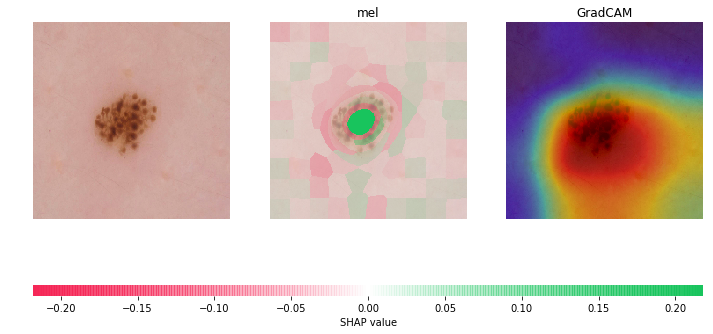

In [13]:
Shap(ind, model, mode)